In [1]:
# Clone the GitHub repository that contains all project code and resources.
!git clone https://github.com/kimzwegz/tpq_project.git

# Install required Python package for connecting to SQL databases (optional, used if connecting to a database via ODBC).
!pip install pyodbc

# Install MLflow for experiment tracking and model versioning.
!pip install mlflow

# Change the working directory to the cloned project folder so that relative file paths work properly.
%cd /content/tpq_project

# Add the project directory to Python's module search path to allow importing local modules and packages.
import sys
sys.path.append('/content/tpq_project')

# Import Colab/Notebook display tools for showing HTML text and images in output cells.
from IPython.display import Image, display, HTML

# IMPORTANT: If this is your first time running the notebook or after installing packages,
# you may need to restart the runtime session for everything to load properly.
# After restarting, re-run the notebook from the beginning.

display(HTML("<b style='color:red;'>📌 Please restart the Colab runtime (Runtime > Restart runtime) and then re-run the notebook to apply all changes.</b>"))


fatal: destination path 'tpq_project' already exists and is not an empty directory.
/content/tpq_project


<h1 style="text-align: center;"><b><u>Mitigating Overfitting in Hyperparameter Selection for Trading Strategies Using Randomized In-Sample Evaluation</u></b></h1>


<p> <b> May 20, 2025 </p>

<h2 style="text-align: left;"><b>Abstract</b></h2>


<p> In quantitative finance and algorithmic trading, hyperparameter tuning is often performed via a traditional train-test split, with the best-performing model on the in-sample data evaluated on a holdout set. However, this approach is prone to overfitting, particularly when evaluating a large grid of parameters, as it optimizes to a single realization of the in-sample period. In this study, we propose a robust method to reduce overfitting by introducing randomized subsampling within the in-sample (training) data. Instead of selecting hyperparameters based solely on performance over a single in-sample period, we compute <b><i>pooled</i></b> Sharpe ratios from multiple random samples of the training set. The hyperparameters with the highest <b><i>pooled</i></b> Sharpe ratio are then tested on the out-of-sample data. We empirically compare this method to the classic approach across a large grid of strategy parameters. Using statistical testing on the ranks of parameter performance, we show that our method yields lower rank divergence between in-sample and out-of-sample performance, indicating a more stable and less overfit model selection process. This framework offers a practical enhancement to hyperparameter selection workflows in trading strategy development. </p>


<h2 style="text-align: left;"><b>Literature Review</b></h2>

<p> Traditional approaches to model evaluation in financial machine learning often rely on train-test splits,
where hyperparameters are selected based on in-sample performance and then validated out-of-sample (Bailey et al., 2014; López de Prado, 2018). However, this method can lead to overfitting, especially when extensive grid searches are used, as it capitalizes on noise within the in-sample period. Various techniques, such as cross-validation and nested cross-validation (Varma & Simon, 2006), have been proposed to mitigate this, though they are less commonly adopted in time-series settings due to data dependencies. To improve robustness, some studies advocate for performance aggregation methods across multiple subsamples (Hansen & Lunde, 2005). In particular, pooling performance metrics like the Sharpe ratio across random subsamples provides a more stable estimator of a strategy’s risk-adjusted return by incorporating variability across multiple data slices (Ledoit & Wolf, 2008). Despite its statistical rigor, pooled Sharpe ratio estimation is underutilized in hyperparameter selection frameworks, motivating its integration into a more robust model selection process. </p>


<h2 style="text-align: left;"><b>Data</b></h2>

<p> This study utilizes a dataset comprising 22 Contract for Difference (CFD) instruments sourced from OANDA, a reputable provider of retail trading data. The dataset spans a five-year period from 2000 to 2004, with a temporal resolution of one hour. After removing incomplete records, the total number of observations across all instruments is 604,321.
Each CFD instrument is individually processed, with its time series divided into an in-sample set (80%) used for model selection and training, and an out-of-sample set (20%) reserved strictly for performance evaluation. To mitigate overfitting during hyperparameter selection, the in-sample data is further subjected to randomized subsampling, where 80% of the in-sample data is randomly shuffled 10 folds each fold is also 80% of the entire insample size. Performance metrics, particularly the Sharpe ratio, are aggregated across these subsamples to compute a pooled estimate, which informs parameter selection. This hierarchical splitting structure allows for a robust assessment of the proposed method’s ability to generalize beyond the specific training realizations.

<h2 style="text-align: left;"><b>Methodology</b></h2>

<h3>Modified MACD Strategy</h3>

<p>
The strategy utilized is the traditional Moving Average Convergence Divergence (MACD) indicator for trend-following, where positions are determined based on the relative strength of the trend. Rather than issuing discrete buy/sell signals, the strategy uses a continuous exposure derived from a normalized-zero-to-one vector for positive MACD histogram values and a normalized-zero-to-negative-one vector for negative values.
</p>


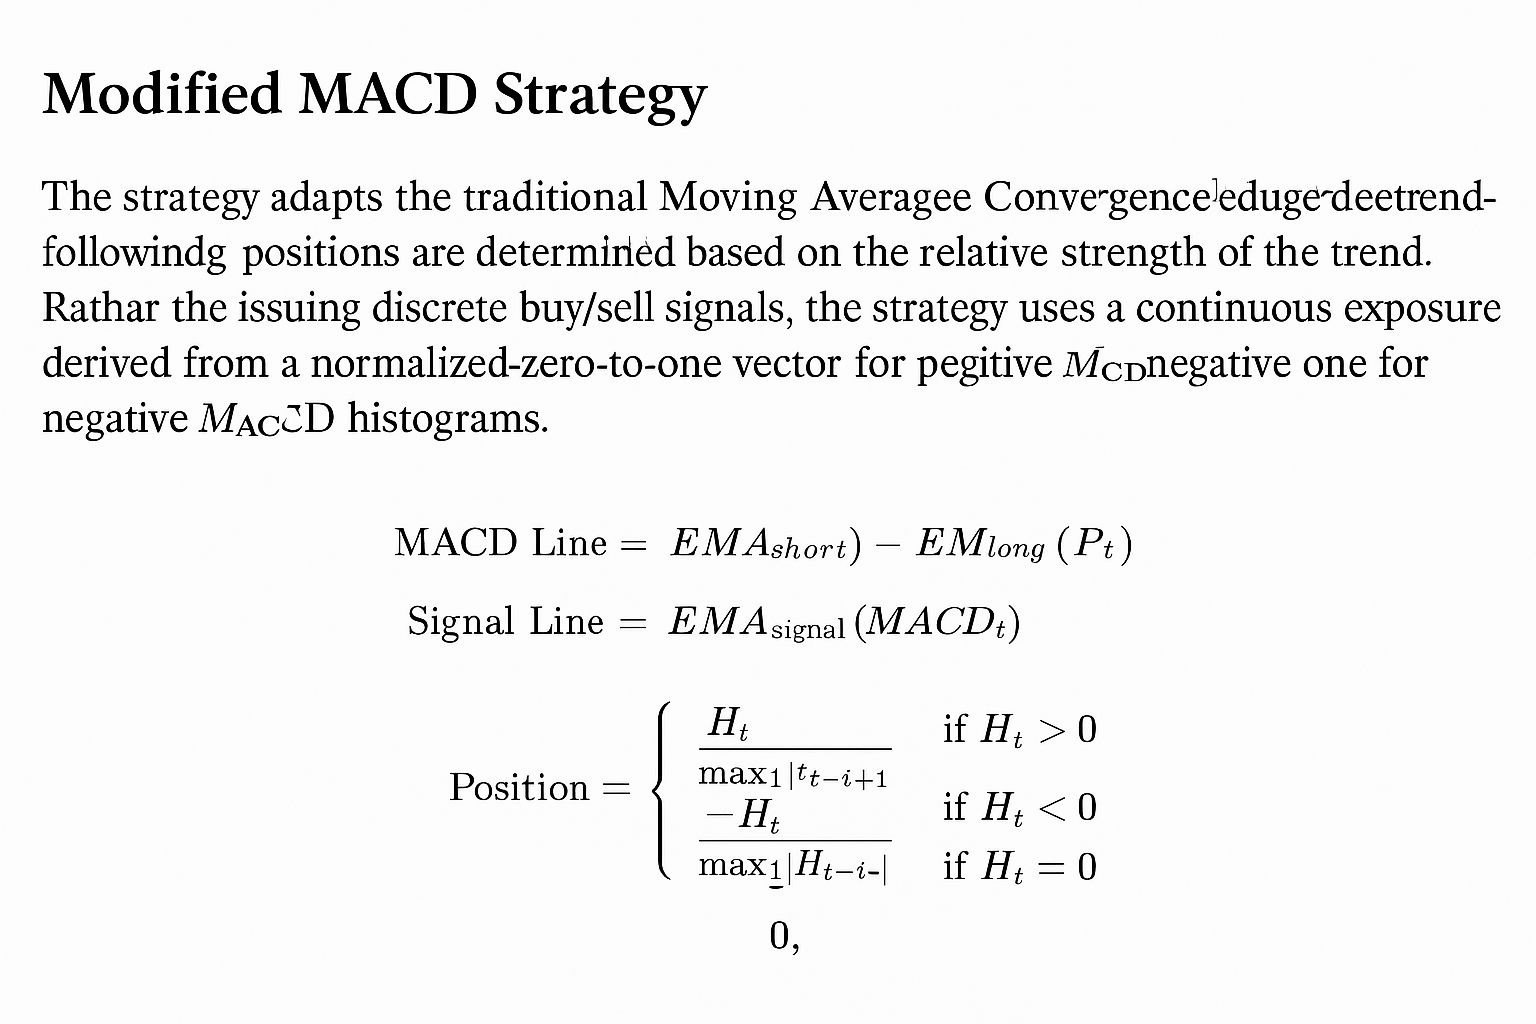

In [2]:
display(Image(filename='./images/macd.png', width=600))

<h3>1. Simple In/Out Sample Splits Evaluation</h3>

<p> To evaluate the robustness of hyperparameter selection in the presence of potential overfitting, we adopt a structured experiment design applied to each of the 22 CFD instruments individually. The dataset for each instrument is split chronologically into two subsets:
In-sample (Training): 80% of the data
Out-of-sample (Testing): 20% of the data
On the in-sample portion, we perform a grid search over a set of hyperparameters for a modified MACD-based trend-following strategy (details provided in a later section). For each parameter combination, we compute the Sharpe ratio and use it to rank the strategies based on their in-sample performance in ascending order where the highest performer would get the highest rank.
Once the best-performing parameters are identified from the in-sample data, we evaluate them on the out-of-sample data using the same Sharpe ratio metric. To measure the consistency of performance, we calculate the absolute value of rank delta—the change in ranking between in-sample and out-of-sample performance—for each parameter set. This rank delta serves as a proxy for the degree of overfitting: large shifts suggest over-optimized parameters that fail to generalize.
</p>

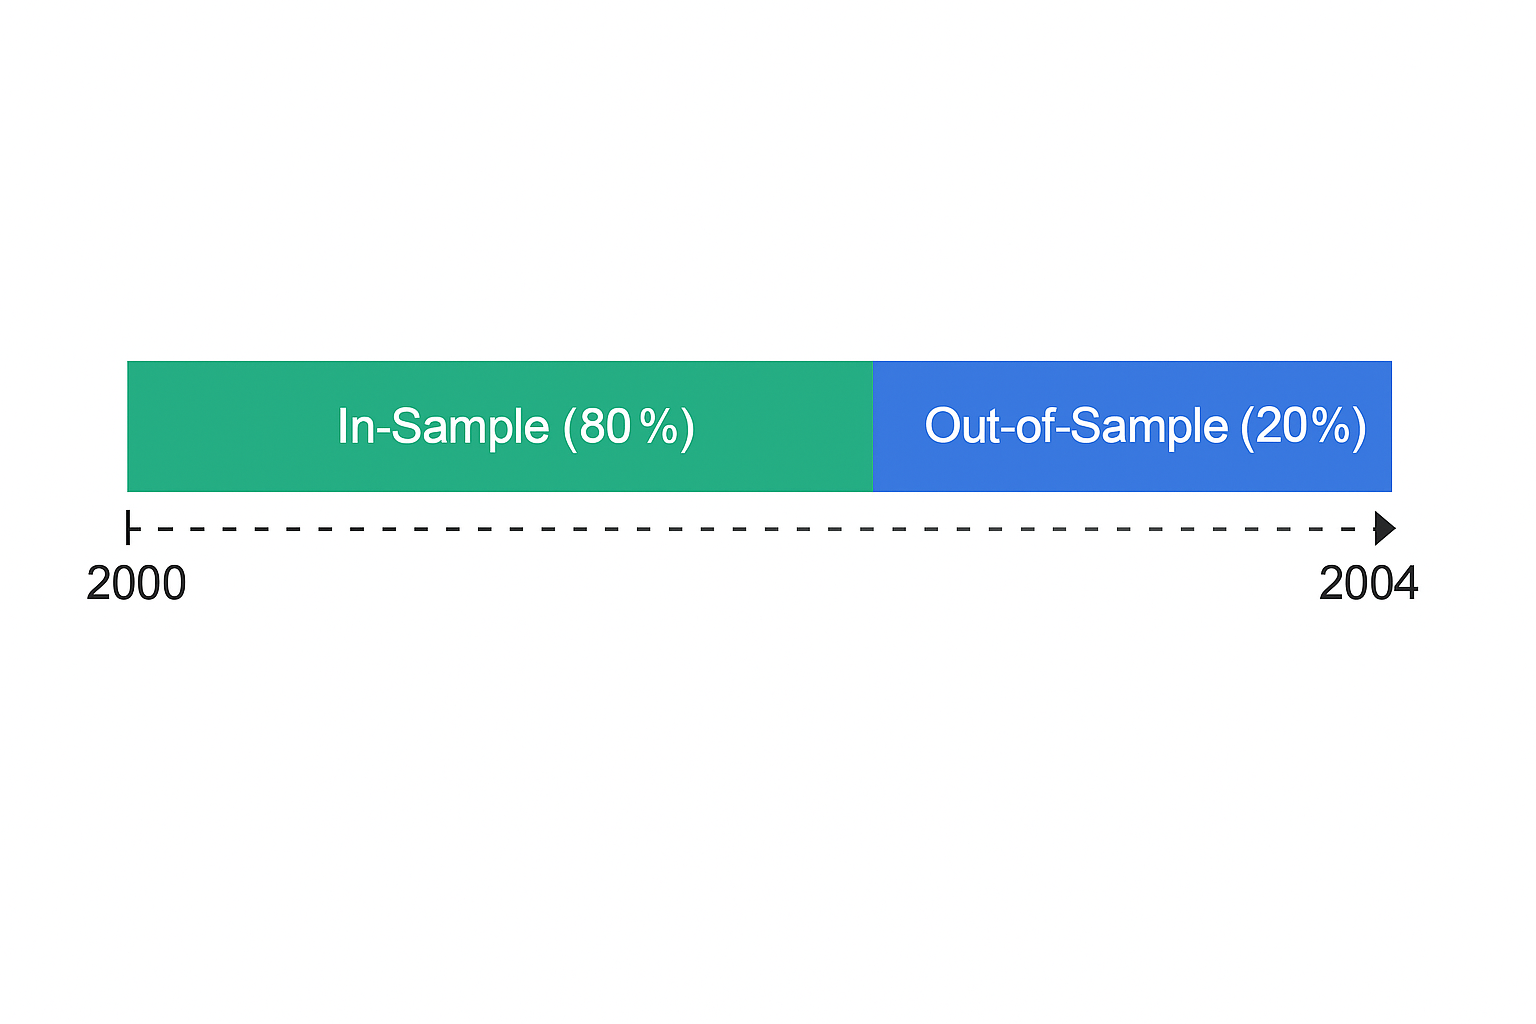

In [3]:
display(Image(filename='./images/sample_split1.png', width=600))


<h3>2. Randomized In/Out Sample Splits Evaluation</h3>

<p>
To enhance the robustness of hyperparameter selection and mitigate overfitting to a single in-sample partition, the in-sample set (80% of the original data) is further subjected to randomized subsampling. Specifically, for each instrument, we perform <b>10 random shuffles</b>, each selecting a random <b>80% subset</b> of the original in-sample data. On each of these randomized folds, the same hyperparameter grid search is executed using a modified MACD trend-following strategy.
</p>

<p>
For every parameter combination evaluated across the folds, we compute the Sharpe ratio based on each fold's return and standard deviation. These Sharpe ratios are then aggregated across the 10 folds using a <b>pooled estimation approach</b>, which accounts for both the weighted average return and the pooled standard deviation.
</p>

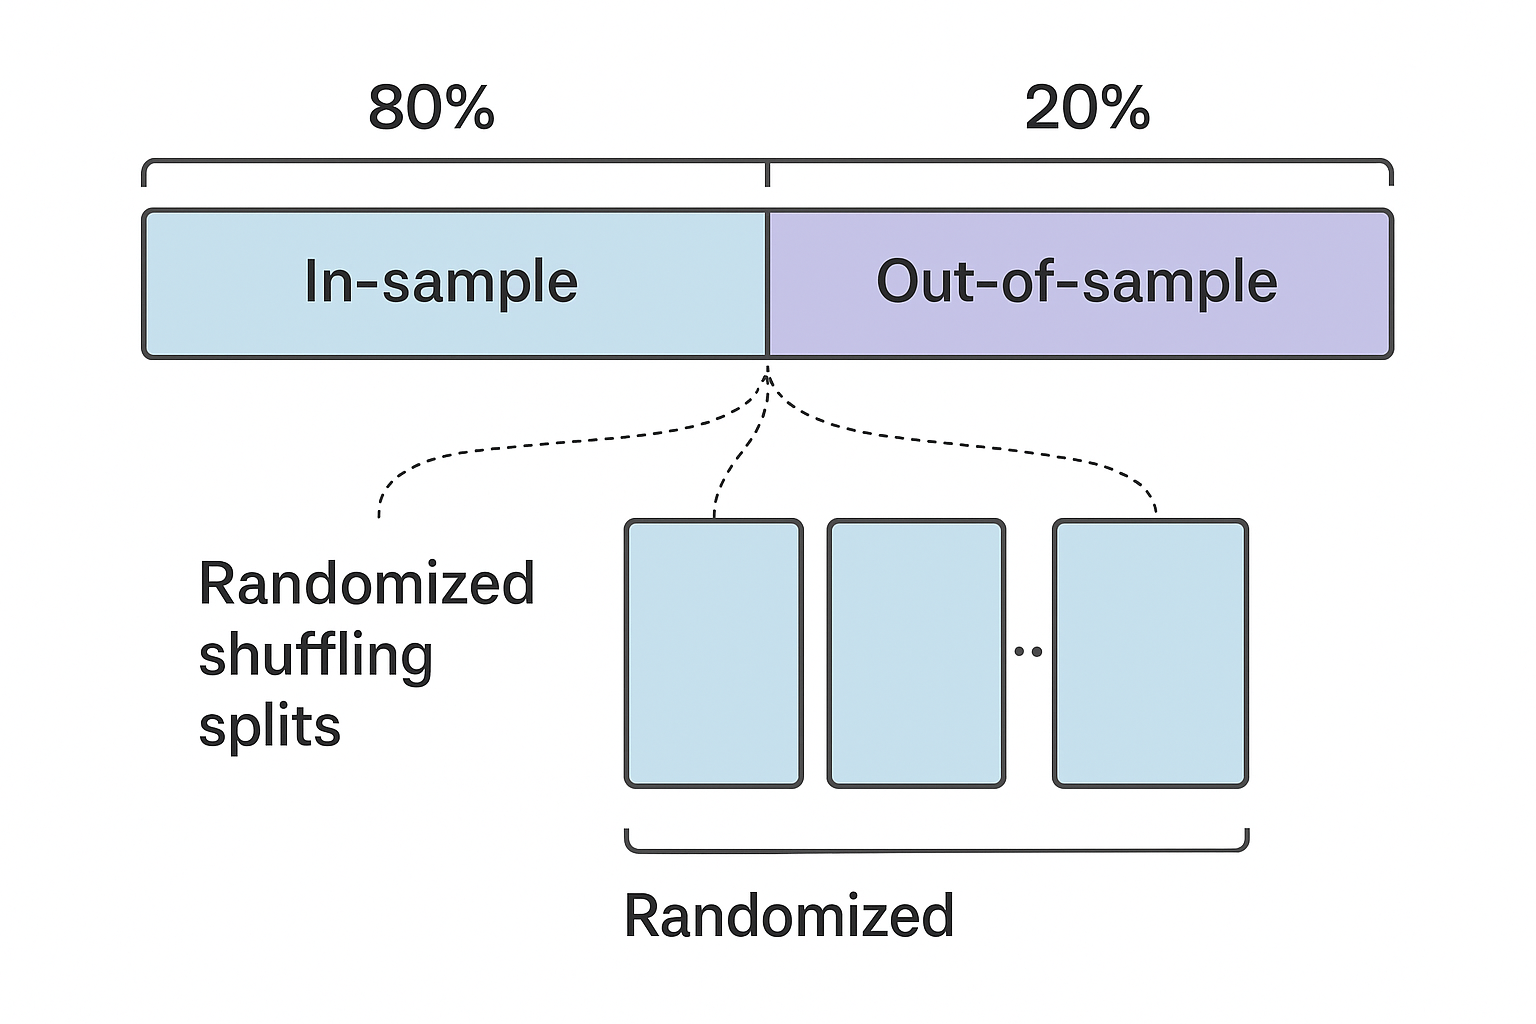

In [4]:
display(Image(filename='./images/sample_split2.png', width=600))




<h3> Pooled Sharpe Ratio Calculation</h3>


<p>
This pooled Sharpe ratio provides a more stable estimate of each parameter combination's performance across multiple randomizations of the in-sample data. After calculating the pooled Sharpe for all parameter sets, we rank them in descending order. This ranking forms the basis for comparison with the out-of-sample performance rankings.
</p>

<div style="text-align: center;">
  <img src="https://github.com/kimzwegz/tpq_project/blob/main/images/pooled_sharpe.png?raw=1" alt="Pooled Sharpe Ratio Formula" width="600">
</div>


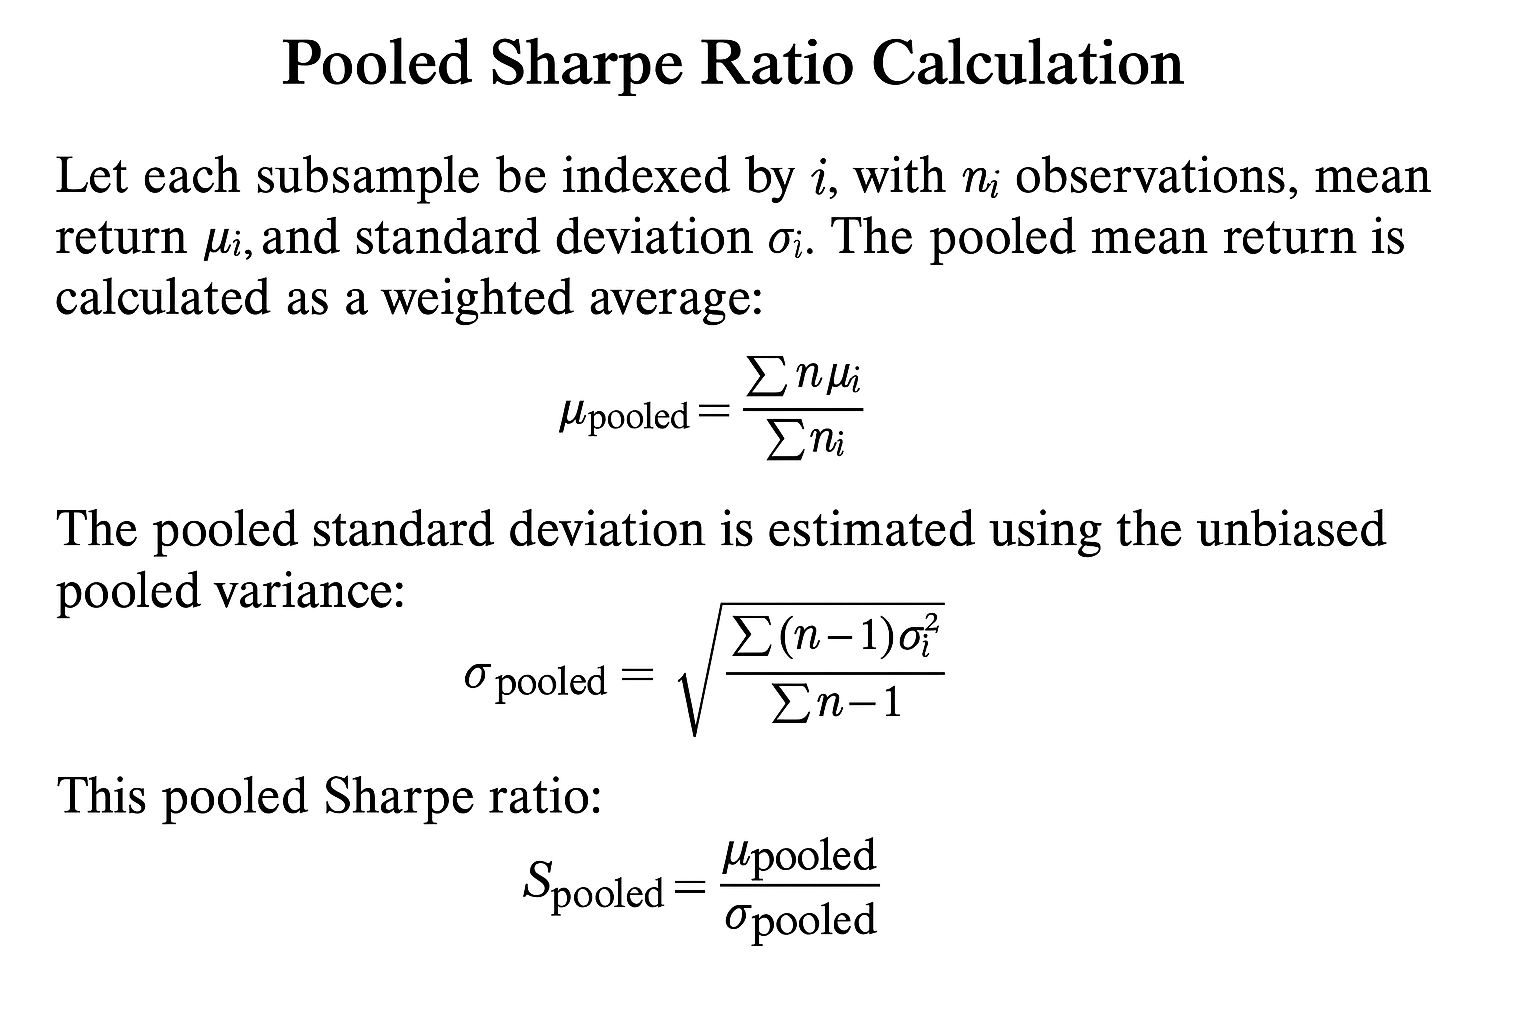

In [5]:
display(Image(filename='./images/pooled_sharpe.png', width=600))

<h2><u><b>Conclusion</b></u></h2>

<p>
The comparative analysis of strategy generalization under simple versus randomized in-sample evaluation reveals meaningful insights into overfitting risk and parameter stability.
While the average out-of-sample return differences were not statistically distinguishable between methods, the randomized selection procedure exhibited a significantly lower rank degradation.
This indicates a stronger preservation of performance orderings when transitioning from in-sample to out-of-sample environments—an essential quality in robust trading strategy design.
</p>

<p>
These results suggest that although return magnitudes may be affected by exogenous market dynamics (e.g., trend absence), ranking consistency provides a more reliable indicator of model generalization.
Accordingly, the following implementation leverages randomized subsampling to mitigate overfitting and improve parameter selection robustness across varying market conditions.
</p>


<h2>References</h2>

<ol>
  <li>
    Bailey, D. H., Borwein, J. M., López de Prado, M., & Zhu, Q. J. (2017).
    <i>The probability of backtest overfitting</i>.
    <i>The Journal of Computational Finance</i>, 20(4), 39–69.
  </li>
  <li>
    López de Prado, M. (2018).
    <i>Advances in Financial Machine Learning</i>.
    John Wiley & Sons.
  </li>
  <li>
    Varma, S., & Simon, R. (2006).
    Bias in error estimation when using cross-validation for model selection.
    <i>BMC Bioinformatics</i>, 7(1), 91.
  </li>
  <li>
    Hansen, P. R., & Lunde, A. (2005).
    Forecast evaluation and combination. In G. Elliott, C. W. J. Granger, & A. Timmermann (Eds.),
    <i>Handbook of Economic Forecasting</i> (Vol. 1, pp. 285–330). Elsevier.
  </li>
  <li>
    Ledoit, O., & Wolf, M. (2008).
    Robust performance hypothesis testing with the Sharpe ratio.
    <i>Journal of Empirical Finance</i>, 15(5), 850–859.
  </li>
</ol>


<hr>

<h2 style="text-align: left;"><b>Python Implementation</b></h2>

<h3 style="text-align: left;"><b> Module imports </b></h3>

<p/> Importing internal and external packages and setting up the notebook to display results </p>

In [6]:
import re
from scipy.stats import t
from os import listdir, path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils.utils import rand_samples, MACD, grid
import logging
import warnings
from scipy.stats import ttest_ind

plt.style.use('ggplot')
logging.basicConfig(level=logging.INFO)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")
%matplotlib inline

<h3 style="text-align: left;"><b> Data </b></h3>

In [7]:
# File paths and constants

folder_main = r'./data_cqf'
folder_data = 'data' # data folder already loaded with all instruments; each instrument is a separate file
folder_backtest = 'backtest' # backtest folder with all backtest results
folder_backtest_in = r'backtest/in' # backtest of grid search results for the 80% of the original insample data
folder_backtest_out = r'backtest/out' # backtest of grid search results for the 20% of the original outsample data
folder_backtest_random = r'../data_cqf/backtest_random' # backtest of random samples performed over the 80% of the original insample data

# load all instrumeents from the data folder
insts_all = list(map(lambda x: x.split('.')[0], listdir(path.join(folder_main, folder_data)))) ## all instruments

print(f'Instruments loaded: {len(insts_all)}\n {insts_all}')

Instruments loaded: 22
 ['US30_USD', 'XCU_USD', 'USB02Y_USD', 'WHEAT_USD', 'SOYBN_USD', 'XAU_USD', 'XAG_USD', 'NATGAS_USD', 'XPT_USD', 'USB05Y_USD', 'JP225_USD', 'NAS100_USD', 'US2000_USD', 'SPX500_USD', 'USB30Y_USD', 'SUGAR_USD', 'BCO_USD', 'XPD_USD', 'WTICO_USD', 'USB10Y_USD', 'CORN_USD', 'CN50_USD']


<hr>
<h4><u><b>Figure/Table</b>: Data Availability</u></h4>

<p>
The table below presents the source data used in the study. The study utilized hourly time series across 22 CFD instruments over a five-year period (2020–2024). Each instrument's total number of valid hourly observations per year is shown in the table.
</p>

<p>
The <b>stacked bar chart</b> (top-left) visualizes the year-wise contribution of each instrument's data volume. This provides insight into how data availability fluctuates across years and instruments. Instruments with consistent availability across all years appear as uniform bands, while those with data gaps or later introductions show visible drops or truncated bars.
</p>

<p>
The <b>bar chart</b> on the top-right quantifies the total number of observations available for each instrument across all years. This highlights which instruments contribute the most (e.g., major indices like JP225, SPX500, and NAS100) and those with relatively lower participation (e.g., soft commodities or shorter history instruments).
</p>

<p>
The <b>area chart</b> (bottom-left) offers a cumulative view of instrument data volume per year. This highlights broader trends such as overall data coverage growth, attrition, or plateaus in availability, helping assess the balance and distribution of the dataset.
</p>

<p>
The final <b>line plot</b> (bottom-right) tracks the yearly total number of hourly observations, summing across all instruments. This gives a high-level overview of the annual data density and consistency of the full panel.
</p>

<p>
Together, these visualizations confirm that the dataset is sufficiently deep and broad across both time and instruments, supporting the robustness of the randomized and pooled backtesting analysis that follows.
</p>


inst                       average / inst  BCO_USD  CN50_USD  CORN_USD  \
no yrs                           5.000000      5.0       5.0       5.0   
average observations/year     5493.827273   5634.0    5165.2    4703.0   
min observations/year         5378.136364   5605.0    5100.0    4626.0   
max observations/year         5563.954545   5671.0    5200.0    4746.0   

inst                       JP225_USD  NAS100_USD  NATGAS_USD  SOYBN_USD  \
no yrs                           5.0         5.0         5.0        5.0   
average observations/year     5894.0      5882.0      5879.6     4724.2   
min observations/year         5819.0      5814.0      5814.0     4652.0   
max observations/year         5930.0      5922.0      5937.0     4784.0   

inst                       SPX500_USD  SUGAR_USD  US2000_USD  US30_USD  \
no yrs                            5.0        5.0         5.0       5.0   
average observations/year      5885.6     2477.8      5880.6    5883.8   
min observations/year          5830.0     2462.0      5819.0    5819.0   
max observations/year          5922.0     2493.0      5922.0    5922.0   

inst                       USB02Y_USD  USB05Y_USD  USB10Y_USD  USB30Y_USD  \
no yrs                            5.0         5.0         5.0         5.0   
average observations/year      5546.8      5857.6      5891.0      5876.2   
min observations/year          4889.0      5807.0      5828.0      5790.0   
max observations/year          5902.0      5905.0      5919.0      5917.0   

inst                       WHEAT_USD  WTICO_USD  XAG_USD  XAU_USD  XCU_USD  \
no yrs                           5.0        5.0      5.0      5.0      5.0   
average observations/year     4712.0     5896.8   5893.4   5893.8   5893.6   
min observations/year         4653.0     5844.0   5838.0   5837.0   5840.0   
max observations/year         4784.0     5928.0   5924.0   5923.0   5931.0   

inst                       XPD_USD  XPT_USD  
no yrs                         5.0      5.0  
average observations/year   5680.8   5712.4  
min observations/year       5317.0   5316.0  
max observations/year       5912.0   5913.0

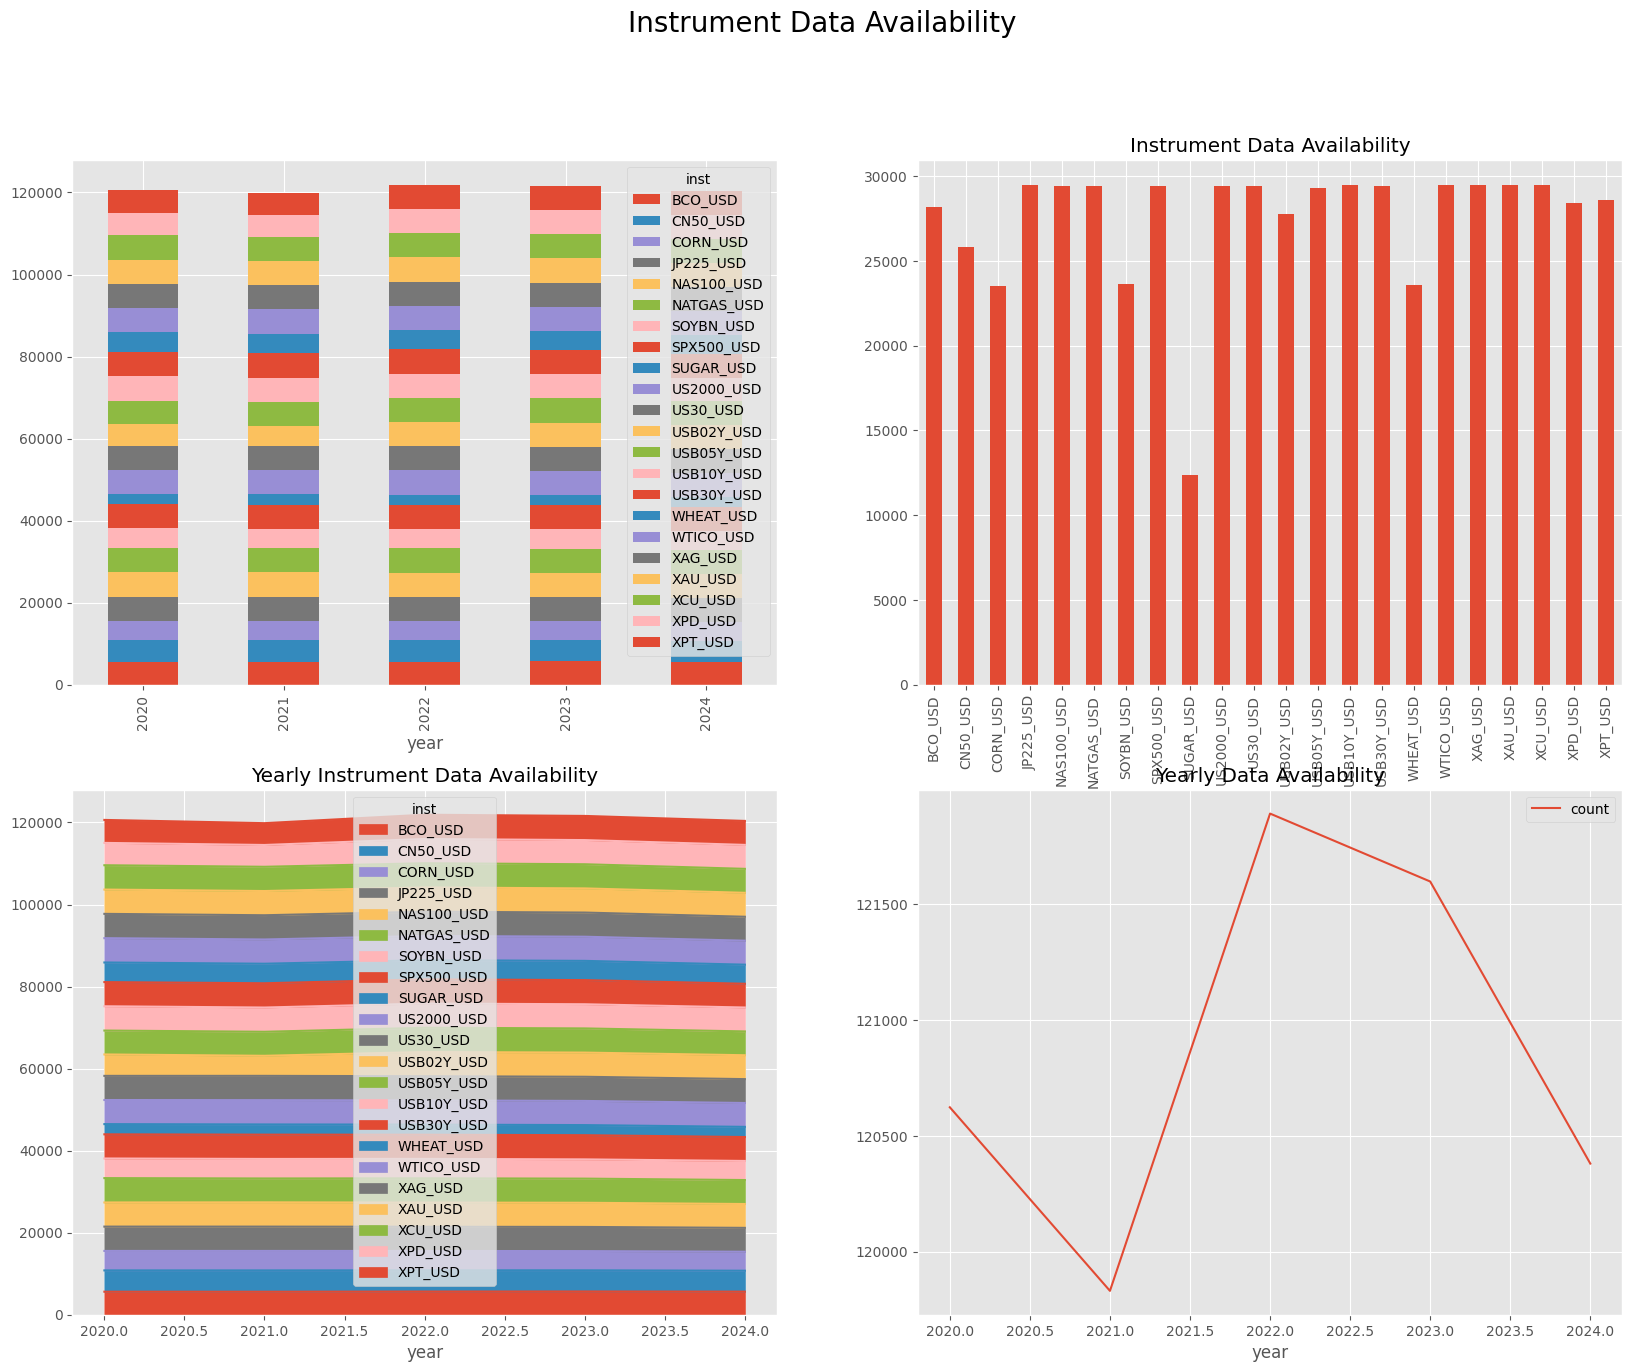

In [8]:
# Loading data and preparing DataFrames

df_raw = pd.concat(list(map(lambda x: pd.read_parquet(path.join(folder_main, folder_data, f'{x}.parquet')), insts_all))) ## reading parquet files for all and concatenating them into a single DataFrame
df_raw['year'] = df_raw.index.year
df_yearinst = df_raw.groupby(['year', 'inst'])['mid'].count().reset_index()
df_inst = df_raw.groupby(['inst'])['mid'].count().reset_index()
df_inst.rename(columns={'mid': 'count'}, inplace=True)
df_year = df_raw.groupby(['year'])['mid'].count().reset_index().set_index('year')
df_year.rename(columns={'mid': 'count'}, inplace=True)


# Pivot the data so each instrument is a column, index is year, values are mid counts
df_pivot = df_yearinst.pivot(index='year', columns='inst', values='mid')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
# Plot stacked bar chart
df_pivot.plot(kind='bar', stacked=True, ax=ax[0, 0])
df_inst.plot.bar(x='inst', y='count', title='Instrument Data Availability', ax=ax[0, 1], legend=False)
df_yearinst.pivot(index='year', columns='inst', values='mid').plot.area(stacked=True, ax=ax[1, 0], title='Yearly Instrument Data Availability')
df_year.plot(title='Yearly Data Availability', ax=ax[1, 1])
fig.suptitle('Instrument Data Availability', fontsize=20)

df_pivot_describe = df_pivot.describe().loc[['count', 'mean', 'min', 'max']]

df_pivot_describe.index=['no yrs', 'average observations/year', 'min observations/year', 'max observations/year']
df_pivot_describe.insert(0, 'average / inst', df_pivot_describe.mean(axis=1))
df_pivot_describe


<h3 style="text-align: left;"><b> Backtest </b></h3>

<h4>Brute Force Grid Search: In / Out Sample Backtest</h4>

<p>
The following function implements a brute force grid search over a specified range of MACD parameters (short EMA, long EMA, and signal EMA) for a given instrument. The strategy logic is encapsulated in the <code>MACD</code> class, which handles the instantiation, backtesting, and metric extraction process.
</p>

<p>
The function accepts a DataFrame containing the instrument's data and performs the grid search using the <code>brute2</code> method from the <code>MACD</code> class. It supports flexible specification of the sample context via the <code>sample</code> argument (either 'in', 'out', or <code>None</code>), and optionally limits the number of observations through <code>sample_size</code>. The backtest results, including the Sharpe ratio and other statistics for each parameter combination, are compiled and returned as a DataFrame. Each result is tagged with the instrument and the corresponding parameter set.
</p>

<p>
This function forms the core of the in-sample and out-of-sample evaluation framework and is used to test how each hyperparameter combination performs on different data partitions.
</p>


In [9]:
def run_backtest(df, range_short, range_long, range_signal, sample_size, sample=None):
    """
    Run a brute-force grid search backtest for a MACD strategy on a given instrument.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing price data for a single instrument. Must include a 'mid' column and 'inst' column.
    range_short : iterable
        Range of values to test for the short EMA window.
    range_long : iterable
        Range of values to test for the long EMA window.
    range_signal : iterable
        Range of values to test for the signal EMA window.
    sample_size : int
        Number of rows to use from the data for the test sample (subset of full instrument data).
    sample : str or None, optional
        Indicates which data sample to use: 'in' for in-sample, 'out' for out-of-sample, or None for full sample.

    Returns
    -------
    pd.DataFrame
        DataFrame containing strategy statistics for each parameter combination, including Sharpe ratio and position sizing.
        Includes columns: 'params', 'inst', and backtest metrics.
    """

    # Extract the instrument name from the DataFrame
    inst = df.inst.unique()[0]

    # Initialize the MACD strategy object for the instrument with input data
    macd = MACD(inst=inst, df=df, col_backtest='mid', col_predict='mid', backtest_sample=sample_size)

    # Print out which sample is being optimized for traceability
    print(f'running {sample} sample brute optimizer for {macd} {inst}')

    # Run the brute-force grid search on the defined parameter ranges
    macd.brute2(
        range_short=range_short,
        range_long=range_long,
        range_signal=range_signal,
        opt_stat='sharpe_mean_annualized',  # Use annualized Sharpe ratio as optimization criterion
        sample=sample                       # Specify in/out/full sample
    )

    # Retrieve the appropriate metrics object based on the sample type
    if sample == 'in':
        metrics = macd.metrics_IN
    elif sample == 'out':
        metrics = macd.metrics_OUT
    else:
        metrics = macd.metrics

    # Get the full strategy performance metrics as a DataFrame
    df_stats = metrics.df_strats_all()

    # Extract numeric values from strategy parameter names and store as string
    df_stats['params'] = df_stats.index.map(lambda x: str(re.findall(r'\d+', x)))

    # Add instrument name to the results for traceability
    df_stats['inst'] = inst

    # Return the full metrics table with strategy evaluation results
    return df_stats


<h4>Randomized In-Sample Grid Search</h4>

<p>
This function extends the brute-force MACD grid search by applying it across <b>multiple randomized in-sample subsets</b> of a given instrument's data. It simulates variability in training data by randomly selecting multiple (e.g., 10) time-based folds from the in-sample period. For each random sample, the MACD grid search is performed using the <code>run_backtest</code> function, and the results are stored.
</p>

<p>
The goal of this approach is to evaluate the stability and robustness of MACD parameter configurations across different market environments, using pooled performance metrics such as the aggregated Sharpe ratio. This technique helps minimize overfitting to a single slice of data and supports more generalizable parameter selection.
</p>


In [10]:
def run_random_backtest(df, range_short, range_long, range_signal, sample_size, n=10, seed_=43):
    """
    Run a randomized backtest across multiple in-sample slices for a single instrument using a MACD strategy.

    This function repeatedly samples random time-contiguous windows from the instrument's data,
    performs a brute-force grid search on each slice, and aggregates the results. The method is used
    to assess parameter robustness by observing their performance across diverse market conditions.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the instrument's price data. Must include 'mid' and 'inst' columns.
    range_short : iterable
        Range of short EMA window lengths to test.
    range_long : iterable
        Range of long EMA window lengths to test.
    range_signal : iterable
        Range of signal EMA window lengths to test.
    sample_size : int
        The number of rows to include in each random sample.
    n : int, optional
        The number of random samples to generate. Default is 10.
    seed_ : int, optional
        Random seed for reproducibility. Default is 43.

    Returns
    -------
    pd.DataFrame
        Concatenated DataFrame containing backtest results for all random samples, including strategy metrics
        and parameter identifiers.
    """
    # Get the instrument identifier from the data
    inst = df.inst.unique()[0]

    # Initialize an empty list to collect DataFrames from each run
    rand = []

    # Initialize a counter for tracking fold number
    counter = 0

    # Loop through n randomly generated index ranges
    for i in rand_samples(df=df, n=n, sample_size=sample_size, seed_=seed_):
        counter += 1
        beg, end = i  # Get start and end indices of the random window

        # Log the range used for this sample
        print(f'rand sample {inst}: {counter}, beg: {beg}, end: {end}')

        # Extract the random time slice of the instrument's data
        df_rand = df.iloc[beg:end]

        # Run the MACD grid search on the selected sample
        df_stats = run_backtest(df_rand, range_short, range_long, range_signal, sample_size, sample=None)

        # Append the result to the list
        rand.append(df_stats)

    # Concatenate all result DataFrames into one
    df_rand = pd.concat(rand)

    # Return the aggregated results
    return df_rand


<h4>Full Backtest Execution Loop for All Instruments</h4>

<p>
This block of code executes the entire backtesting pipeline for all instruments in the dataset. For each instrument, it loads the historical data, defines a grid of MACD hyperparameters, and runs a brute-force grid search to evaluate strategy performance on three data partitions: <b>in-sample</b> (80%), <b>out-of-sample</b> (20%), and <b>full-sample</b> (100%). Each result is saved into an HDF5 file using an appropriate key (e.g., 'in', 'out', 'all').
</p>

<p>
In addition to the standard splits, the code also performs <b>randomized in-sample backtests</b> by drawing multiple overlapping 80% windows from the in-sample data and re-running the MACD grid search on each fold. This approach supports robust evaluation and helps to detect parameter sets that generalize well across varying sample windows. All results are stored in a single HDF5 file per instrument, enabling unified post-analysis.
</p>


In [11]:
# ## THIS BLOCK TAKES APROX 160 minutes to run on a 4-core CPU with 32GB RAM
# ## THE SCRIPT SAVES THE RESULTS IN A PARQUET FILE FOR EACH INSTRUMENT AND LATER PICKS UP ON THE FOLLOWING CODE BLOCKS. YOU DO NOT NEED TO RUN IT AGAIN UNLESS YOU WANT TO RE-CALCULATE THE RESULTS.

# # Define search ranges for MACD parameters
# range_short = (24, 264, 24)    # Short EMA range: from 1 day to 11 days (in 24-hour increments)
# range_long = (120, 800, 120)   # Long EMA range: from 5 to 33 days (in 120-hour increments)
# range_signal = (24, 120, 48)   # Signal EMA range: from 1 to 5 days (in 48-hour increments)
# sample_size = 0.8              # 80% of the data will be used for in-sample

# # Print the total number of grid combinations being tested
# print(f'length of grid: {len(grid(range_short, range_long, range_signal))}')

# # Loop through each instrument in the full list
# counter = 1
# for inst in insts_all:
#     print(f'processing instrument {counter}/{len(insts_all)}: {inst}')

#     # Define file paths for reading data and writing backtest results
#     filename = f'{inst}.parquet'
#     path_data = path.join(folder_main, folder_data, filename)
#     path_backtest = path.join(folder_main, folder_backtest, f'{inst}.h5')

#     # Load the instrument's price data
#     df = pd.read_parquet(path_data)

#     # Run in-sample grid search and save results under 'in' key
#     df_stats = run_backtest(
#         df=df,
#         range_short=range_short,
#         range_long=range_long,
#         range_signal=range_signal,
#         sample_size=sample_size,
#         sample='in'
#     )
#     df_stats.to_hdf(path_backtest, key='in', mode='w')

#     # Run backtest on both out-of-sample (20%) and full sample (100%)
#     for s in ['out', None]:
#         df_stats = run_backtest(
#             df=df,
#             range_short=range_short,
#             range_long=range_long,
#             range_signal=range_signal,
#             sample_size=sample_size,
#             sample=s
#         )
#         # Save results to appropriate key
#         if s is None:
#             df_stats.to_hdf(path_backtest, key='all', mode='a')  # Full-sample
#         else:
#             df_stats.to_hdf(path_backtest, key=s, mode='a')      # Out-of-sample

#     # Run randomized in-sample backtests (e.g., 10 folds of 80% of in-sample)
#     df_rand = run_random_backtest(
#         df=df,
#         range_short=range_short,
#         range_long=range_long,
#         range_signal=range_signal,
#         sample_size=sample_size,
#         n=10
#     )
#     # Save the randomized results
#     df_rand.to_hdf(path_backtest, key='rand', mode='a')

#     # Increment instrument counter
#     counter += 1


<h3 style="text-align: left;"><b> Results </b></h3>

<h4>Compare In-Sample vs Out-of-Sample Strategy Statistics</h4>

<p>
This function loads backtest results for a given instrument and compares the performance of each parameter configuration between the <b>in-sample</b> and <b>out-of-sample</b> data. It calculates key metrics such as the mean return, standard deviation, and Sharpe ratio for both splits, assigns rankings based on the in-sample Sharpe ratio, and computes absolute performance deltas.
</p>

<p>
In addition, the function performs a two-sample t-test on the mean return differences, estimating the standard error, t-statistic, degrees of freedom, and p-value. The resulting DataFrame includes a rich set of comparative metrics per parameter set, organized in a hierarchical structure for easy analysis.
</p>


In [12]:
def get_stats(inst):
    """
    Retrieve and compare in-sample vs. out-of-sample backtest metrics for a given instrument.

    This function loads backtest results for a specific instrument from disk, calculates
    Sharpe ratios, assigns ranks, and compares in- and out-of-sample performance using
    both absolute deltas and a two-sample t-test.

    Parameters
    ----------
    inst : str
        The instrument identifier (used to locate its saved backtest file).
    top : int, optional
        Reserved for future use (e.g., returning only the top N parameter sets).

    Returns
    -------
    df_stats_inst_compare : pd.DataFrame
        A multi-index DataFrame comparing in-sample and out-of-sample statistics for each
        parameter configuration. Includes Sharpe ratio deltas, t-test statistics, and p-values.
    inst : str
        The instrument identifier, returned for convenience.
    """

    # Construct file path to the backtest results for the instrument
    path_backtest = path.join(folder_main, folder_backtest, f'{inst}.h5')

    # Metrics to extract and compare
    cols_metrics = ['returns_mean', 'std', 'sharpe', 'rank_sharpe']
    stats = []

    # Load and process results for both 'in' and 'out' samples
    for s in ['in', 'out']:
        df_stats = pd.read_hdf(path_backtest, key=s)  # Load HDF5 table
        df_stats['sample'] = s

        # Compute Sharpe ratio manually
        df_stats['sharpe'] = df_stats['returns_mean'] / df_stats['std']

        # Rank by Sharpe ratio (lower rank is better)
        df_stats.sort_values('sharpe', ascending=True, inplace=True)
        df_stats.reset_index(drop=False, inplace=True)
        df_stats.rename(columns={'index': 'id'}, inplace=True)
        df_stats['rank_sharpe'] = df_stats.index + 1

        # Collect in/out sample data
        stats.append(df_stats)

    # Combine the stats into a single DataFrame
    df_stats_inst = pd.concat(stats)

    # Pivot so we can compare in vs out per parameter
    df_stats_inst_compare = df_stats_inst.pivot(index='params', columns='sample', values=cols_metrics + ['total_obs'])

    # Rank by in-sample Sharpe ratio (descending, best first)
    df_stats_inst_compare.sort_values(('rank_sharpe', 'in'), inplace=True, ascending=False)

    # Calculate absolute differences between in and out for each metric
    for metric in cols_metrics:
        df_stats_inst_compare[(metric, 'diff')] = (
            df_stats_inst_compare[(metric, 'in')] - df_stats_inst_compare[(metric, 'out')]
        ).abs()

    # Ensure metrics are consistently ordered by column
    df_stats_inst_compare.sort_index(axis=1, inplace=True)

    # Calculate standard error for the difference in means
    df_stats_inst_compare[('se', 'tstats')] = np.sqrt(
        (df_stats_inst_compare['std', 'in'] / df_stats_inst_compare['total_obs', 'in']) +
        (df_stats_inst_compare['std', 'out'] / df_stats_inst_compare['total_obs', 'out'])
    )

    # Compute t-statistic for difference in returns
    df_stats_inst_compare[('t', 'tstats')] = (
        df_stats_inst_compare[('returns_mean', 'diff')] / df_stats_inst_compare[('se', 'tstats')]
    )

    # Degrees of freedom for two-sample t-test
    df_stats_inst_compare[('df', 'tstats')] = (
        df_stats_inst_compare['total_obs', 'in'] + df_stats_inst_compare['total_obs', 'out'] - 2
    )

    # Compute two-tailed p-value from t-statistic
    df_stats_inst_compare[('p', 'tstats')] = 2 * (
        1 - t.cdf(np.abs(df_stats_inst_compare[('t', 'tstats')]),
                  df_stats_inst_compare[('df', 'tstats')])
    )

    # Round p-values for presentation
    df_stats_inst_compare[('p', 'tstats')] = df_stats_inst_compare[('p', 'tstats')].apply(lambda x: round(x, 2))

    # Final sort to ensure top Sharpe-ranked in-sample parameters are first
    df_stats_inst_compare.sort_values(('rank_sharpe', 'in'), ascending=False, inplace=True)
    df_stats_inst_compare.sort_index(axis=1, inplace=True)

    return df_stats_inst_compare, inst


<h4>Summarize Top Strategy Performance and Rank Stability</h4>

<p>
This function generates a summary of how well the top-performing MACD parameter configurations for a given instrument generalize from in-sample to out-of-sample evaluation. It selects a user-defined subset of top-ranked parameter sets and computes the average absolute differences in Sharpe ratio, mean returns, and rank position.
</p>


In [13]:
def summarize_stats(inst, top: list):
    df_stats_inst_compare = get_stats(inst)[0]
    df_top_sharpe = df_stats_inst_compare.loc[df_stats_inst_compare.index.isin(top), :]

    stats_inst = {
        inst: {
            'params': str(df_top_sharpe.index.tolist()),

            # In-sample values
            'sharpe.in': df_top_sharpe[('sharpe', 'in')].values[0],
            'rank_sharpe.in': df_top_sharpe[('rank_sharpe', 'in')].values[0],
            'returns_mean.in': df_top_sharpe[('returns_mean', 'in')].values[0],

            # Out-of-sample values
            'sharpe.out': df_top_sharpe[('sharpe', 'out')].values[0],
            'rank_sharpe.out': df_top_sharpe[('rank_sharpe', 'out')].values[0],
            'returns_mean.out': df_top_sharpe[('returns_mean', 'out')].values[0],

            # Differences
            'sharpe.diff': df_top_sharpe[('sharpe', 'diff')].values[0],
            'rank_sharpe.diff': df_top_sharpe[('rank_sharpe', 'diff')].values[0],
            'returns_mean.diff': df_top_sharpe[('returns_mean', 'diff')].values[0],
            'returns_mean.p': df_top_sharpe[('p', 'tstats')].values[0],



        }
    }

    df_stats_top = pd.DataFrame(stats_inst).T
    return df_stats_top


<h4>Pooled Performance Statistics from Randomized In-Sample Folds</h4>

<p>
This function processes the results of randomized in-sample backtests for a given instrument and calculates <b>pooled performance metrics</b> across multiple folds. These randomized samples are used to evaluate the stability and robustness of each MACD parameter configuration.
</p>

<p>
For each parameter set, the function aggregates the mean return, standard deviation, and Sharpe ratio, and then computes a <b>pooled Sharpe ratio</b> using weighted averages of returns and unbiased estimates of variance. The results are ranked by pooled Sharpe performance, providing a more reliable metric for parameter selection than a single split. The final output is a ranked table of parameter sets based on their aggregated performance.
</p>


In [14]:
def get_stats_rand(inst):
    """
    Compute pooled Sharpe ratio and performance metrics from randomized in-sample backtests.

    This function reads the results of randomized grid searches for a specific instrument,
    aggregates metrics across the random folds, and computes the pooled Sharpe ratio for
    each parameter configuration using weighted statistics. Parameter sets are then ranked
    by their pooled Sharpe score.

    Parameters
    ----------
    inst : str
        The instrument identifier used to locate its saved randomized backtest results.

    Returns
    -------
    df_rand_calc : pd.DataFrame
        A DataFrame with one row per parameter configuration, including:
        - Weighted mean return and pooled standard deviation
        - Pooled Sharpe ratio
        - Rank based on pooled Sharpe
        - Aggregate statistics across folds
    """

    # Load randomized backtest results for the instrument
    path_backtest = path.join(folder_main, folder_backtest, f'{inst}.h5')
    df_rand = pd.read_hdf(path_backtest, key='rand')

    # Compute individual Sharpe ratios per fold
    df_rand['sharpe'] = df_rand['returns_mean'] / df_rand['std']

    # Compute weighted return and unbiased variance for each fold
    df_rand['returns_mean_weighted'] = df_rand['returns_mean'] * df_rand['total_obs']
    df_rand['var'] = df_rand['std'] ** 2
    df_rand['var_weighted'] = df_rand['var'] * (df_rand['total_obs'] - 1)

    # Group by instrument and parameter set, then aggregate metrics across folds
    df_rand_calc = df_rand.groupby(['inst', 'params']).agg(
        returns_mean_mean=pd.NamedAgg(column="returns_mean", aggfunc="mean"),
        returns_mean_annualized_mean=pd.NamedAgg(column="returns_mean_annualized", aggfunc="mean"),
        sharpe_mean_annualized_mean=pd.NamedAgg(column="sharpe_mean_annualized", aggfunc="mean"),
        std_mean=pd.NamedAgg(column="std", aggfunc="mean"),
        std_annualized_mean_mean=pd.NamedAgg(column="std_annualized", aggfunc="mean"),
        n_groups=pd.NamedAgg(column="total_obs", aggfunc="count"),
        total_obs=pd.NamedAgg(column="total_obs", aggfunc="sum"),
        returns_mean_weighted_sum=pd.NamedAgg(column="returns_mean_weighted", aggfunc="sum"),
        var_weighted_sum=pd.NamedAgg(column="var_weighted", aggfunc="sum"),
    )

    # Compute weighted average return
    df_rand_calc['returns_mean_wa'] = df_rand_calc['returns_mean_weighted_sum'] / df_rand_calc['total_obs']

    # Compute pooled standard deviation using unbiased pooled variance
    df_rand_calc['std_pooled'] = np.sqrt(
        df_rand_calc['var_weighted_sum'] / (df_rand_calc['total_obs'] - df_rand_calc['n_groups'])
    )

    # Compute pooled Sharpe ratio
    df_rand_calc['sharpe_pooled'] = df_rand_calc['returns_mean_wa'] / df_rand_calc['std_pooled']

    # Sort by pooled Sharpe to assign ranking
    df_rand_calc.sort_values('sharpe_pooled', ascending=True, inplace=True)
    df_rand_calc.reset_index(drop=False, inplace=True)
    df_rand_calc.rename(columns={'index': 'id'}, inplace=True)
    df_rand_calc['rank_sharpe'] = df_rand_calc.index + 1

    # Re-sort in descending order (best performing first)
    df_rand_calc.sort_values('sharpe_pooled', ascending=False, inplace=True)

    return df_rand_calc


<h4>Evaluate Top In-Sample Strategy Across All Instruments</h4>

<p>
This block identifies the best-performing MACD parameter set (based on in-sample Sharpe ratio) for each instrument and evaluates how well that top parameter generalizes to out-of-sample data. For each instrument, it uses the <code>get_stats</code> function to retrieve in/out sample comparison metrics and selects the top-ranked parameter set based on in-sample Sharpe. Then, using <code>summarize_stats</code>, it computes performance deltas and rank correlation metrics (e.g., Spearman, Kendall) to quantify the consistency of that top parameter's performance.
</p>

<p>
All summary statistics are aggregated into a single DataFrame across instruments, allowing for cross-sectional analysis of model robustness and generalization quality. The final DataFrame includes measures such as Sharpe ratio differences, rank consistency, and statistical test p-values.
</p>


In [15]:
# Initialize a list to store top strategy stats for each instrument
top_inout = []

# Loop through all instruments
for inst in insts_all:

    # Retrieve the full in/out-sample comparison DataFrame for the instrument
    df_stats_top, inst = get_stats(inst)

    # Select the top-performing parameter based on in-sample Sharpe rank
    top_param = df_stats_top.head(1).index.tolist()

    # Summarize its generalization performance (across in/out sample)
    df_stats_top = summarize_stats(inst, top_param)

    # Append the summary to the results list
    top_inout.append(df_stats_top)

# Concatenate all instrument-level summaries into one DataFrame
df_top_inout = pd.concat(top_inout)

# Ensure all numeric columns are properly typed as float (for plotting/stats)
for c in df_top_inout.columns:
    if c != 'params':
        df_top_inout[c] = df_top_inout[c].astype('float')


<hr>
<h4> <u> <b> Table</b>: Comparison of Backtest Results Between In & Out of Sample from Simple In/Out Sample Splits  </u> </h4>

<p>
The table below presents the evaluation of the top-performing MACD parameter set (selected based on in-sample Sharpe ratio) for each of 21 CFD instruments. The analysis includes the in-sample and out-of-sample values of Sharpe ratios, rank positions, and mean returns, followed by their absolute differences. These metrics allow us to assess both the quality and stability of strategy performance when deployed on unseen data.
</p>

<ul>
  <li><b>sharpe.in / sharpe.out</b> — Sharpe ratio computed on in-sample and out-of-sample data, respectively.</li>
  <li><b>rank_sharpe.in / rank_sharpe.out</b> — Rank of the parameter based on Sharpe ratio in in-sample and out-of-sample contexts (lower is better).</li>
  <li><b>returns_mean.in / returns_mean.out</b> — Mean return in in-sample and out-of-sample periods.</li>
  <li><b>sharpe.diff</b> — Absolute difference between in-sample and out-of-sample Sharpe ratios.</li>
  <li><b>rank_sharpe.diff</b> — Absolute change in Sharpe-based rank.</li>
  <li><b>returns_mean.diff</b> — Absolute difference in mean return between in and out of sample.</li>
  <li><b>returns_mean.p</b> — p-value from a two-sample t-test assessing whether the difference in mean returns is statistically significant.</li>
</ul>

<p>

In [16]:
ordered_cols = [
    'params',
    'sharpe.in', 'sharpe.out',
    'rank_sharpe.in', 'rank_sharpe.out',
    'returns_mean.in', 'returns_mean.out',
    'sharpe.diff', 'rank_sharpe.diff', 'returns_mean.diff', 'returns_mean.p'
]

df_top_inout = df_top_inout[ordered_cols]
df_top_inout

params  sharpe.in  sharpe.out  \
US30_USD     ["['216', '600', '72', '30']"]   0.006321   -0.000226   
XCU_USD            ["['240', '720', '72']"]   0.003516    0.010190   
USB02Y_USD   ["['240', '480', '72', '02']"]   0.004370    0.000713   
WHEAT_USD           ["['24', '120', '24']"]   0.008591   -0.014891   
SOYBN_USD           ["['24', '120', '24']"]   0.003242   -0.017305   
XAU_USD             ["['72', '240', '24']"]   0.009411   -0.000042   
XAG_USD             ["['24', '120', '72']"]   0.014140   -0.003381   
NATGAS_USD          ["['24', '120', '24']"]   0.008819   -0.003512   
XPT_USD             ["['72', '120', '72']"]   0.011107    0.003851   
USB05Y_USD   ["['216', '720', '72', '05']"]   0.001145    0.000409   
JP225_USD   ["['240', '720', '72', '225']"]   0.004711    0.013447   
NAS100_USD  ["['240', '720', '72', '100']"]   0.001088   -0.000553   
US2000_USD  ["['72', '720', '72', '2000']"]   0.006144    0.004204   
SPX500_USD  ["['240', '720', '72', '500']"]   0.005192   -0.000764   
USB30Y_USD   ["['240', '720', '72', '30']"]   0.003424    0.007147   
SUGAR_USD          ["['216', '480', '24']"]   0.016332    0.014391   
BCO_USD             ["['24', '120', '24']"]   0.008864   -0.002281   
XPD_USD             ["['48', '120', '72']"]   0.015547    0.010628   
WTICO_USD          ["['240', '720', '24']"]   0.008091   -0.018425   
USB10Y_USD   ["['240', '720', '72', '10']"]   0.000433    0.002823   
CORN_USD            ["['24', '120', '24']"]  -0.000218   -0.007165   
CN50_USD     ["['120', '240', '72', '50']"]   0.004737    0.017617   

            rank_sharpe.in  rank_sharpe.out  returns_mean.in  \
US30_USD             106.0              5.0     1.009830e-05   
XCU_USD              106.0             27.0     5.203664e-06   
USB02Y_USD           106.0             93.0     5.982749e-07   
WHEAT_USD            106.0             31.0     1.659663e-05   
SOYBN_USD            106.0              1.0     3.222700e-06   
XAU_USD              106.0             21.0     6.594780e-06   
XAG_USD              106.0              2.0     2.273127e-05   
NATGAS_USD           106.0              1.0     2.375278e-05   
XPT_USD              106.0            101.0     2.115969e-05   
USB05Y_USD           106.0             35.0     3.114904e-07   
JP225_USD            106.0             43.0     6.950458e-06   
NAS100_USD           106.0             40.0     2.029969e-06   
US2000_USD           106.0             22.0     1.057956e-05   
SPX500_USD           106.0             44.0     8.425033e-06   
USB30Y_USD           106.0              3.0     2.242361e-06   
SUGAR_USD            106.0             60.0     4.296997e-05   
BCO_USD              106.0             78.0     2.351267e-05   
XPD_USD              106.0             93.0     4.398740e-05   
WTICO_USD            106.0             12.0     2.650630e-05   
USB10Y_USD           106.0              7.0     1.528954e-07   
CORN_USD             106.0             13.0    -2.565139e-07   
CN50_USD             106.0            105.0     5.584549e-06   

            returns_mean.out  sharpe.diff  rank_sharpe.diff  \
US30_USD       -1.951801e-07     0.006547             101.0   
XCU_USD         1.641711e-05     0.006674              79.0   
USB02Y_USD      9.603153e-08     0.003657              13.0   
WHEAT_USD      -2.340557e-05     0.023482              75.0   
SOYBN_USD      -1.559304e-05     0.020548             105.0   
XAU_USD        -3.366004e-08     0.009453              85.0   
XAG_USD        -5.301258e-06     0.017521             104.0   
NATGAS_USD     -1.035735e-05     0.012331             105.0   
XPT_USD         5.604809e-06     0.007256               5.0   
USB05Y_USD      1.148838e-07     0.000736              71.0   
JP225_USD       2.649904e-05     0.008736              63.0   
NAS100_USD     -6.861193e-07     0.001642              66.0   
US2000_USD      5.840888e-06     0.001941              84.0   
SPX500_USD     -7.028965e-07     0.005956              62.0   
USB30Y_U

<hr>


<h4>Evaluation of Top Pooled Sharpe Strategies from Randomized In-Sample Folds</h4>

<p>
This block identifies and evaluates the best-performing MACD parameter set for each instrument based on the <b>pooled Sharpe ratio</b> computed across multiple randomized in-sample folds. The goal is to determine whether the parameter set that performs most consistently across different random in-sample windows also generalizes well to out-of-sample data.
</p>

<p>
For each instrument, the function <code>get_stats_rand</code> retrieves aggregated results from 10 randomized folds. The parameter set with the highest pooled Sharpe ratio is selected, and its performance is summarized using <code>summarize_stats</code>, which computes in/out-sample performance, absolute differences in key metrics, and a p-value for the return difference. The final output is a summary table across all instruments.
</p>


In [17]:
# Initialize an empty list to collect summary results for all instruments
top_in_out_rand = []

# Loop through each instrument in the list
for inst in insts_all:

    # Load pooled Sharpe performance metrics from randomized folds
    df_stats_rand = get_stats_rand(inst)

    # Select the parameter set with the highest pooled Sharpe ratio
    top_rand = df_stats_rand.head(1).params.tolist()

    # Evaluate the selected top parameter using in/out-sample statistics
    df_stats_rand = summarize_stats(inst, top_rand)

    # Append the result to the collection list
    top_in_out_rand.append(df_stats_rand)

# Concatenate all individual summaries into a single DataFrame
df_top_in_out_rand = pd.concat(top_in_out_rand)

# Convert all numeric columns to float for compatibility (except 'params')
for c in df_top_in_out_rand.columns:
    if c != 'params':
        df_top_in_out_rand[c] = df_top_in_out_rand[c].astype('float')

<hr>
<h4> <u> <b> Table </b>: Comparison of Backtest Results Between In & Out of Sample from Randomized In Sample Splits vs Holdout Out of Sample </u> </h4>

<p>
The table below (<code>df_top_in_out_rand</code>) presents the evaluation of the best-performing MACD parameter set for each of 21 CFD instruments, where the top configuration is selected using the <b>pooled Sharpe ratio</b> across multiple <b>randomized in-sample folds</b>. This approach simulates variability in the in-sample training window and aims to identify parameter sets that generalize better by avoiding overfitting to any single data split.
</p>

In [18]:
# View the final table summarizing all instruments' top pooled strategies
df_top_in_out_rand

params  sharpe.in  rank_sharpe.in  \
US30_USD     ["['240', '360', '72', '30']"]   0.005778            95.0   
XCU_USD            ["['240', '600', '72']"]   0.003457           105.0   
USB02Y_USD    ["['24', '120', '24', '02']"]  -0.000406             5.0   
WHEAT_USD           ["['24', '120', '24']"]   0.008591           106.0   
SOYBN_USD           ["['24', '120', '24']"]   0.003242           106.0   
XAU_USD            ["['192', '240', '72']"]   0.003505            26.0   
XAG_USD             ["['24', '480', '24']"]   0.013538           103.0   
NATGAS_USD          ["['24', '120', '24']"]   0.008819           106.0   
XPT_USD             ["['48', '120', '72']"]   0.010974           105.0   
USB05Y_USD    ["['24', '120', '24', '05']"]  -0.002636            51.0   
JP225_USD    ["['96', '120', '72', '225']"]   0.001912            41.0   
NAS100_USD   ["['24', '120', '24', '100']"]  -0.003096            70.0   
US2000_USD  ["['48', '120', '72', '2000']"]   0.005262            63.0   
SPX500_USD  ["['240', '480', '24', '500']"]   0.003509            80.0   
USB30Y_USD   ["['240', '720', '72', '30']"]   0.003424           106.0   
SUGAR_USD           ["['48', '120', '72']"]   0.011803            24.0   
BCO_USD             ["['24', '120', '24']"]   0.008864           106.0   
XPD_USD             ["['72', '120', '72']"]   0.015222           105.0   
WTICO_USD           ["['24', '120', '24']"]   0.007457           102.0   
USB10Y_USD    ["['24', '120', '24', '10']"]  -0.001485            44.0   
CORN_USD           ["['240', '720', '72']"]  -0.002722            93.0   
CN50_USD      ["['96', '240', '72', '50']"]   0.004549           104.0   

            returns_mean.in  sharpe.out  rank_sharpe.out  returns_mean.out  \
US30_USD       8.857549e-06    0.003045             12.0      2.601061e-06   
XCU_USD        5.118883e-06    0.010082             24.0      1.609445e-05   
USB02Y_USD    -4.622104e-08   -0.002112             53.0     -2.082512e-07   
WHEAT_USD      1.659663e-05   -0.014891             31.0     -2.340557e-05   
SOYBN_USD      3.222700e-06   -0.017305              1.0     -1.559304e-05   
XAU_USD        2.815622e-06    0.006323            105.0      6.210941e-06   
XAG_USD        2.078507e-05    0.000163             17.0      2.424579e-07   
NATGAS_USD     2.375278e-05   -0.003512              1.0     -1.035735e-05   
XPT_USD        1.990084e-05    0.000275             79.0      3.806795e-07   
USB05Y_USD    -5.377619e-07    0.001703             42.0      3.574727e-07   
JP225_USD      2.474585e-06    0.011049             10.0      1.876504e-05   
NAS100_USD    -3.951044e-06    0.014428            102.0      1.424912e-05   
US2000_USD     8.296869e-06    0.011710             89.0      1.510310e-05   
SPX500_USD     4.687203e-06    0.000149             48.0      1.233696e-07   
USB30Y_USD     2.242361e-06    0.007147              3.0      5.374611e-06   
SUGAR_USD      2.958199e-05    0.011447             34.0      3.458424e-05   
BCO_USD        2.351267e-05   -0.002281             78.0     -3.139949e-06   
XPD_USD        4.354511e-05    0.011039             95.0      2.510477e-05   
WTICO_USD      2.051805e-05   -0.003495             94.0     -4.997849e-06   
USB10Y_USD    -3.622369e-07    0.002616              3.0      7.437681e-07   
CORN_USD      -5.294119e-06    0.004519            106.0      7.747069e-06   
CN50_USD       5.241098e-06    0.016171            102.0      3.312347e-05   

            sharpe.diff  rank_sharpe.diff  returns_mean.diff  returns_mean.p  
US30_USD       0.002733              83.0       6.256488e-06            0.99  
XCU_USD        0.006625              81.0       1.097556e-05            0.99  
USB02Y_USD     0.001706              48.0       1.620302e-07            1.00  
WHEAT_USD      0.023482              75.0       4.000220e-05            0.95  
SOYBN_USD      0.020548             105.0       1.881574e-05            0.97  
XAU_USD        0.002818              79.0       3.395319e-06     

<hr>

In [19]:
# Create comparison DataFrame
df_compare = pd.DataFrame({
    'Simple In/Out Sample splits: Abs(rank delta)': df_top_inout['rank_sharpe.diff'],
    'Randomized In/Out Sample splits: Abs(rank delta)': df_top_in_out_rand['rank_sharpe.diff'],
    'In-Sample Rank Diff': df_top_inout['returns_mean.diff'],
    'Randomized Pooled Rank Diff': df_top_in_out_rand['returns_mean.diff']

})

df_compare['Randomized In/Out Sample splits: Abs(returns delta)'] = df_top_in_out_rand['returns_mean.diff']
df_compare['Simple In/Out Sample splits: Abs(returns delta)'] = df_top_inout['returns_mean.diff']

df_compare.index.name = 'instrument'


compare_overall = df_compare.mean(axis=0)
compare_overall.name = 'Overall average'
df_compare = pd.concat([df_compare, compare_overall.to_frame().T])


df_compare.loc[df_compare['Randomized In/Out Sample splits: Abs(rank delta)'] < df_compare['Simple In/Out Sample splits: Abs(rank delta)'], 'Improved Ranking'] = True
df_compare.loc[~(df_compare['Randomized In/Out Sample splits: Abs(rank delta)'] < df_compare['Simple In/Out Sample splits: Abs(rank delta)']), 'Improved Ranking'] = False

df_compare.loc[df_compare['Randomized In/Out Sample splits: Abs(returns delta)'] < df_compare['Simple In/Out Sample splits: Abs(returns delta)'], 'Improved Abs Returns Delta'] = True
df_compare.loc[~(df_compare['Randomized In/Out Sample splits: Abs(returns delta)'] < df_compare['Simple In/Out Sample splits: Abs(returns delta)']), 'Improved Abs Returns Delta'] = False

<hr>
<h4><u><b>Figure/Table</b>: Comparison of Strategy Robustness — Simple vs. Randomized Evaluation</u></h4>

<p>
The table and charts below compare the generalization performance of MACD strategy parameters selected via two methods:
</p>
<ul>
  <li><b>Simple In/Out Sample Split</b> — Selecting the top parameter from a single fixed in-sample period.</li>
  <li><b>Randomized In-Sample Folds (Pooled Sharpe)</b> — Selecting the top parameter based on pooled performance across randomized splits of the in-sample data.</li>
</ul>

<p>
Each row in the table corresponds to a financial instrument. The columns show:
</p>
<ul>
  <li><b>Abs(rank delta)</b>: The absolute difference in Sharpe-based rank from in-sample to out-of-sample.</li>
  <li><b>Abs(returns delta)</b>: The absolute difference in mean return from in-sample to out-of-sample.</li>
  <li><b>Improved Ranking</b>: Whether the randomized method led to a lower rank difference compared to the simple split.</li>
  <li><b>Improved Abs Returns Delta</b>: Whether the randomized method reduced the out-of-sample return error.</li>
</ul>

<p>
<b>Chart 1:</b> The first bar chart compares the <b>absolute rank difference</b> for each instrument under both selection methods. In most cases, the <span style="color:green;"><b>randomized pooled Sharpe method shows a lower rank delta</b></span>, indicating greater stability in strategy performance when evaluated on out-of-sample data.
</p>

<p>
<b>Chart 2:</b> The second chart compares the <b>absolute difference in mean returns</b> between in- and out-of-sample. A <span style="color:green;"><b>lower return delta</b></span> under the randomized method suggests better generalization and reduced overfitting.
</p>

<p>
<b>Summary Observations:</b>
</p>
<ul>
  <li><b>Ranking Improvement:</b> The randomized pooled approach improved ranking stability in <b>15 out of 22</b> instruments (≈ 68%).</li>
  <li><b>Return Stability:</b> It also reduced the mean return delta in <b>11 out of 22</b> instruments (≈ 50%).</li>
  <li><b>Average Absolute Rank Delta:</b> Dropped from <b>67.95</b> (simple) to <b>46.95</b> (randomized).</li>
  <li><b>Average Absolute Return Delta:</b> Dropped from <b>1.63e-05</b> (simple) to <b>1.46e-05</b> (randomized).</li>
</ul>

<p>
These findings provide evidence that incorporating randomness into in-sample evaluation — combined with pooling metrics such as Sharpe ratio — leads to more robust parameter selection, reducing the risk of overfitting and improving out-of-sample generalization.
</p>


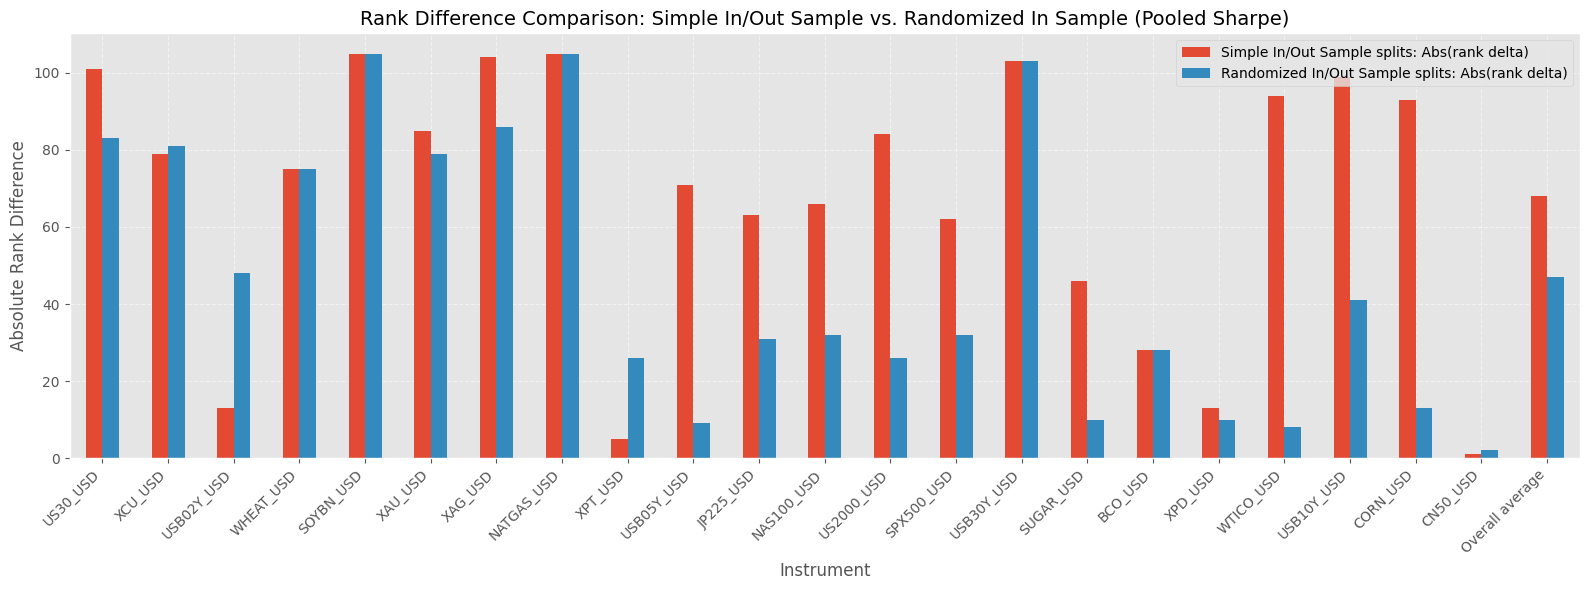

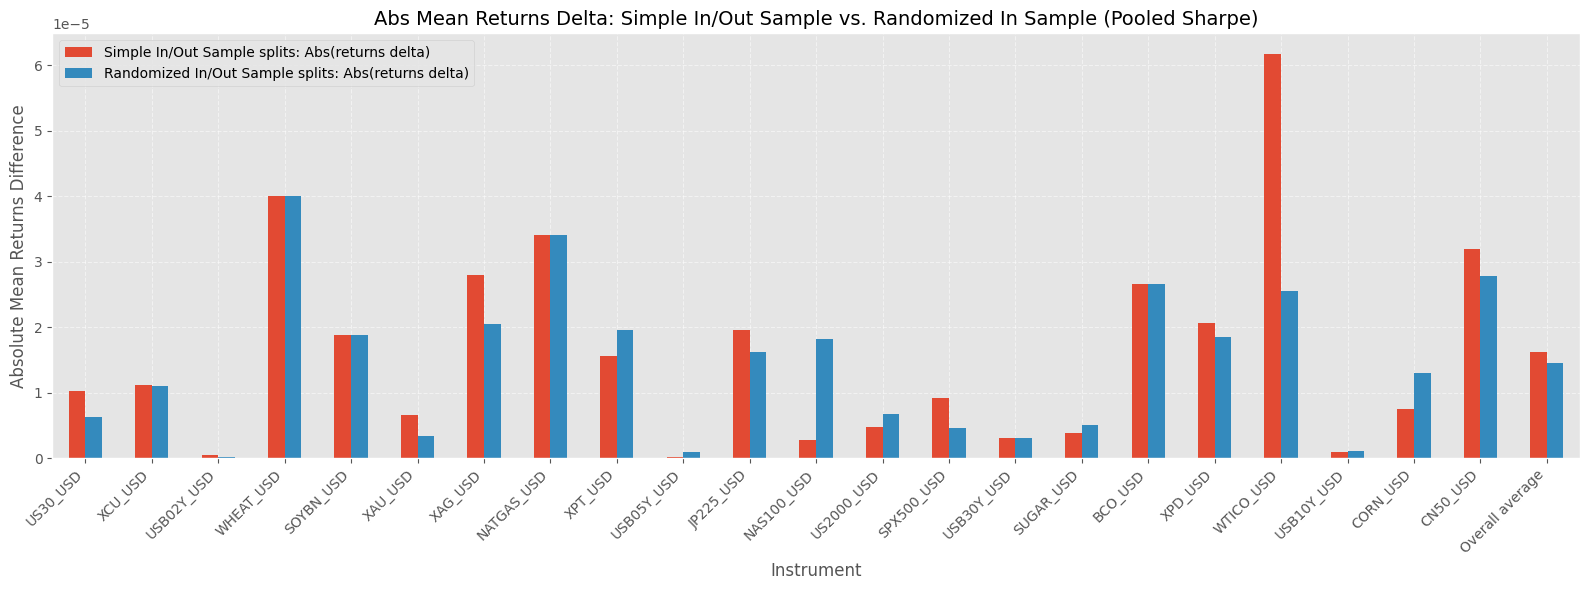

Simple In/Out Sample splits: Abs(rank delta)  \
US30_USD                                           101.000000   
XCU_USD                                             79.000000   
USB02Y_USD                                          13.000000   
WHEAT_USD                                           75.000000   
SOYBN_USD                                          105.000000   
XAU_USD                                             85.000000   
XAG_USD                                            104.000000   
NATGAS_USD                                         105.000000   
XPT_USD                                              5.000000   
USB05Y_USD                                          71.000000   
JP225_USD                                           63.000000   
NAS100_USD                                          66.000000   
US2000_USD                                          84.000000   
SPX500_USD                                          62.000000   
USB30Y_USD                                         103.000000   
SUGAR_USD                                           46.000000   
BCO_USD                                             28.000000   
XPD_USD                                             13.000000   
WTICO_USD                                           94.000000   
USB10Y_USD                                          99.000000   
CORN_USD                                            93.000000   
CN50_USD                                             1.000000   
Overall average                                     67.954545   

                 Randomized In/Out Sample splits: Abs(rank delta)  \
US30_USD                                                83.000000   
XCU_USD                                                 81.000000   
USB02Y_USD                                              48.000000   
WHEAT_USD                                               75.000000   
SOYBN_USD                                              105.000000   
XAU_USD                                                 79.000000   
XAG_USD                                                 86.000000   
NATGAS_USD                                             105.000000   
XPT_USD                                                 26.000000   
USB05Y_USD                                               9.000000   
JP225_USD                                               31.000000   
NAS100_USD                                              32.000000   
US2000_USD                                              26.000000   
SPX500_USD                                              32.000000   
USB30Y_USD                                             103.000000   
SUGAR_USD                                               10.000000   
BCO_USD                                                 28.000000   
XPD_USD                                                 10.000000   
WTICO_USD                                                8.000000   
USB10Y_USD                                              41.000000   
CORN_USD                                                13.000000   
CN50_USD                                                 2.000000   
Overall average                                         46.954545   

                 In-Sample Rank Diff  Randomized Pooled Rank Diff  \
US30_USD                1.029348e-05                 6.256488e-06   
XCU_USD                 1.121344e-05                 1.097556e-05   
USB02Y_USD              5.022434e-07                 1.620302e-07   
WHEAT_USD               4.000220e-05                 4.000220e-05   
SOYBN_USD               1.881574e-05                 1.881574e-05   
XAU_USD                 6.628440e-06                 3.395319e-06   
XAG_USD                 2.803253e-05                 2.054261e-05   
NATGAS_USD              3.411012e-05                 3.411012e-05   
XPT_USD                 1.555488e-05                 1.952016e-05   
USB05Y_USD              1.966066e-07                 8.952346e-07   
JP225_USD               1.954859e-05    

In [20]:
# Create comparison DataFrame
df_compare = pd.DataFrame({
    'Simple In/Out Sample splits: Abs(rank delta)': df_top_inout['rank_sharpe.diff'],
    'Randomized In/Out Sample splits: Abs(rank delta)': df_top_in_out_rand['rank_sharpe.diff'],
    'In-Sample Rank Diff': df_top_inout['returns_mean.diff'],
    'Randomized Pooled Rank Diff': df_top_in_out_rand['returns_mean.diff']

})

df_compare['Randomized In/Out Sample splits: Abs(returns delta)'] = df_top_in_out_rand['returns_mean.diff']
df_compare['Simple In/Out Sample splits: Abs(returns delta)'] = df_top_inout['returns_mean.diff']

df_compare.index.name = 'instrument'


compare_overall = df_compare.mean(axis=0)
compare_overall.name = 'Overall average'
df_compare = pd.concat([df_compare, compare_overall.to_frame().T])


df_compare.loc[df_compare['Randomized In/Out Sample splits: Abs(rank delta)'] < df_compare['Simple In/Out Sample splits: Abs(rank delta)'], 'Improved Ranking'] = True
df_compare.loc[~(df_compare['Randomized In/Out Sample splits: Abs(rank delta)'] < df_compare['Simple In/Out Sample splits: Abs(rank delta)']), 'Improved Ranking'] = False

df_compare.loc[df_compare['Randomized In/Out Sample splits: Abs(returns delta)'] < df_compare['Simple In/Out Sample splits: Abs(returns delta)'], 'Improved Abs Returns Delta'] = True
df_compare.loc[~(df_compare['Randomized In/Out Sample splits: Abs(returns delta)'] < df_compare['Simple In/Out Sample splits: Abs(returns delta)']), 'Improved Abs Returns Delta'] = False
df_compare

# Plot
ax = df_compare[['Simple In/Out Sample splits: Abs(rank delta)',	'Randomized In/Out Sample splits: Abs(rank delta)']].plot(kind='bar', figsize=(16, 6))
ax.set_title('Rank Difference Comparison: Simple In/Out Sample vs. Randomized In Sample (Pooled Sharpe)', fontsize=14)
ax.set_ylabel('Absolute Rank Difference')
ax.set_xlabel('Instrument')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot
ax = df_compare[['Simple In/Out Sample splits: Abs(returns delta)', 'Randomized In/Out Sample splits: Abs(returns delta)']].plot(kind='bar', figsize=(16, 6))
ax.set_title('Abs Mean Returns Delta: Simple In/Out Sample vs. Randomized In Sample (Pooled Sharpe)', fontsize=14)
ax.set_ylabel('Absolute Mean Returns Difference')
ax.set_xlabel('Instrument')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

df_compare

<h4><u>Statistical Comparison: Randomized vs. Simple In/Out Splits</u></h4>

<p>
To evaluate whether the <b>randomized pooled sampling approach</b> improves generalization compared to the standard fixed in/out split, we conducted two one-sided Welch’s t-tests.
</p>

<ol>
  <li>
    <b>Ranking Stability Test</b><br>
    This test compares the average absolute change in Sharpe-based rank (<code>rank_sharpe.diff</code>) between in-sample and out-of-sample periods.
    <ul>
      <li><i>Null Hypothesis:</i> No improvement from randomized sampling.</li>
      <li><i>Alternative Hypothesis:</i> Randomized sampling yields smaller rank deltas, indicating more stable strategy performance.</li>
      <li><i>Method:</i> Welch’s t-test with <code>alternative='less'</code>.</li>
    </ul>
  </li>

  <li>
    <b>Mean Return Stability Test</b><br>
    This test compares the absolute change in mean returns (<code>returns_mean.diff</code>) across the two sampling methods.
    <ul>
      <li><i>Null Hypothesis:</i> No difference in return stability between methods.</li>
      <li><i>Alternative Hypothesis:</i> Randomized method yields smaller return differences out-of-sample.</li>
      <li><i>Unit:</i> Results are expressed in basis points (bps) for interpretability.</li>
    </ul>
  </li>
</ol>

<p>
Both tests use <code>equal_var=False</code> to account for unequal variances (Welch’s correction). The table below summarizes the results, including:
</p>

<ul>
  <li>Average absolute differences under each method</li>
  <li>t-statistics and p-values assessing the statistical significance of observed improvements</li>
</ul>

<p>
This statistical analysis helps validate whether the performance improvements observed through randomized evaluation are significant and not due to chance.
</p>


In [21]:
# --- T-test for absolute Sharpe rank difference ---

# Perform a one-sided Welch's t-test comparing the rank difference between the randomized and simple splits.
# The test checks whether the randomized sampling leads to significantly smaller absolute changes in Sharpe-based ranks.
# 'equal_var=False' uses Welch’s correction for unequal variances.
# 'alternative="less"' means the test checks if the randomized sample has a lower mean than the simple sample.
t_stat_rank, p_value_rank = ttest_ind(
    df_top_in_out_rand['rank_sharpe.diff'],  # Sample A: Rank differences from randomized in-sample evaluation
    df_top_inout['rank_sharpe.diff'],        # Sample B: Rank differences from fixed in/out split evaluation
    equal_var=False,
    alternative='less'  # One-sided: Is Sample A < Sample B?
)

# Display the test results for ranking stability
print(f"t-statistic Ranking: {t_stat_rank:.4f}")
print(f"p-value Ranking: {p_value_rank:.4f}")

# --- T-test for absolute mean return difference ---

# Same structure as above, now evaluating whether the randomized sampling yields smaller differences in mean return.
# Results are used to test the hypothesis that pooled randomized evaluation is more stable in returns as well.
t_stat_mean, p_value_mean = ttest_ind(
    df_top_in_out_rand['returns_mean.diff'],  # Sample A: Mean return differences from randomized sampling
    df_top_inout['returns_mean.diff'],        # Sample B: Mean return differences from fixed split
    equal_var=False,
    alternative='less'  # One-sided test: Does Sample A have lower mean than Sample B?
)

# Display the test results for mean return stability
print(f"t-statistic Mean: {t_stat_mean:.4f}")
print(f"p-value Mean: {p_value_mean:.4f}")

# --- Summary Table ---

# Construct a summary DataFrame that presents:
# 1. The average absolute rank and return deltas for both sampling methods
# 2. The corresponding t-statistics and p-values from the two tests above
# Note: Return deltas are scaled to basis points (bps) for interpretability
df_tstat = pd.DataFrame(data={
    'Abs (Rank delta)': [
        df_top_in_out_rand['rank_sharpe.diff'].mean(),  # Randomized average
        df_top_inout['rank_sharpe.diff'].mean(),        # Simple split average
        t_stat_rank,                                    # t-statistic
        p_value_rank                                    # p-value
    ],
    'Abs (Mean Returns delta) - bps': [
        df_top_in_out_rand['returns_mean.diff'].mean() * 10000,  # Randomized in bps
        df_top_inout['returns_mean.diff'].mean() * 10000,        # Simple split in bps
        t_stat_mean,                                             # t-statistic
        p_value_mean                                             # p-value
    ],
},
index=[
    'Randomized In/Out Sample splits',
    'Simple In/Out Sample splits',
    'tstat',
    'pvalue'
])


t-statistic Ranking: -1.9699
p-value Ranking: 0.0277
t-statistic Mean: -0.4035
p-value Mean: 0.3444


<hr>
<h4><u><b>Statistical Evaluation of Strategy Generalization: Randomized vs. Simple In/Out Splits</b></u></h4>

<p>
This section compares the generalization ability of trading strategies selected using two methods:
</p>
<ul>
  <li><b>Simple In/Out Sample Splits</b>: Traditional 80/20 split between training and test sets.</li>
  <li><b>Randomized In/Out Sample Splits</b>: Strategy parameters selected based on pooled Sharpe ratios from randomized in-sample folds.</li>
</ul>

<p>
<b>Mean Return Stability:</b><br>
The average absolute difference in mean returns (in basis points) between in- and out-of-sample was <b>0.1627</b> bps using the simple split, and slightly lower at <b>0.1461</b> bps with randomized sampling. However, this difference was <b>not statistically significant</b> (t-statistic = -0.40, p = 0.3444). The lack of significance could be due to an overall absence of exploitable trends (identified by the MACD indicator) in some of the out-of-sample periods, rather than overfitting per se.
</p>

<p>
<b>Sharpe Rank Stability:</b><br>
The absolute difference in Sharpe-based ranking dropped from <b>67.95</b> (simple split) to <b>46.95</b> (randomized), a <b>statistically significant improvement</b> (t-statistic = -1.97, p = 0.0277). This indicates that the randomized selection method produces more stable and robust parameter rankings when tested out-of-sample.
</p>

<p>
<b>Conclusion:</b><br>
While the mean return deltas were statistically similar, the significant reduction in ranking instability strongly supports the use of randomized parameter selection. This approach mitigates overfitting risk and leads to more generalizable strategy choices across financial instruments.
</p>


In [22]:
df_tstat

Abs (Rank delta)  \
Randomized In/Out Sample splits         46.954545   
Simple In/Out Sample splits             67.954545   
tstat                                   -1.969864   
pvalue                                   0.027736   

                                 Abs (Mean Returns delta) - bps  
Randomized In/Out Sample splits                        0.146050  
Simple In/Out Sample splits                            0.162741  
tstat                                                 -0.403544  
pvalue                                                 0.344392